# 读入数据

In [4]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# 读入调查问卷

In [6]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    #"eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
data["survey"] = survey

# 添加DBN列

In [7]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# 将列内容转换为数值类型

In [8]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# 压缩数据集

In [9]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# 将AP分数转换为数值类型

In [10]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# 合并数据集

In [11]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# 为映射添加学区列

In [12]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# 计算相关性

In [120]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 66, dtype: float64


In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

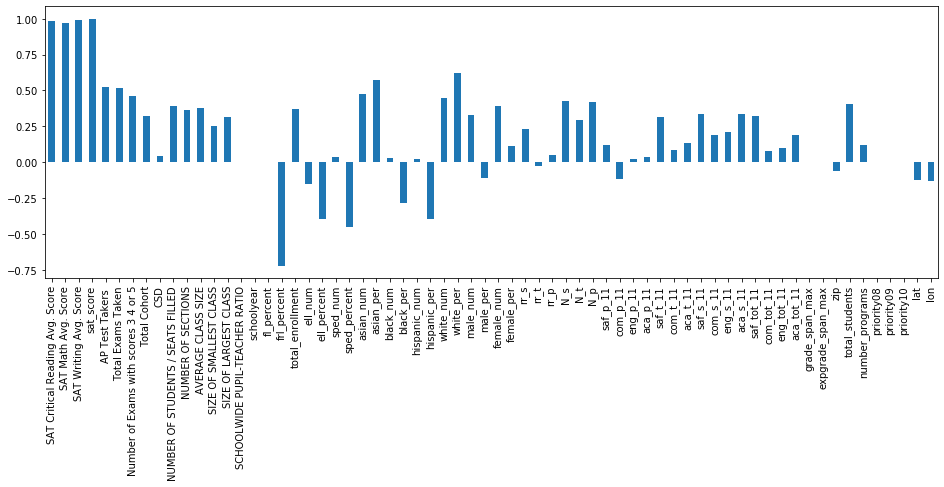

In [15]:
correlations.plot(kind='bar',figsize=(16,5))

SAT Critical Reading Avg.Score、SAT Math Avg.Score、SAT Writing Avg.Score和sat_score与sat_score有很强相关性。

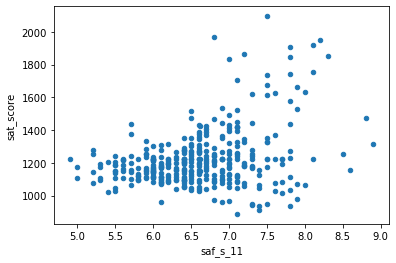

In [132]:
combined.plot.scatter(x='saf_s_11', y='sat_score')


安全系数saf_s_11和SAT成绩，由之前计算可以知道相关系数为0.337639呈正相关，由散点图也可以看出sat_score随saf_s_11的增长呈缓慢增长趋势。

In [17]:
safe = combined.groupby("saf_s_11").agg(numpy.mean)
safe.reset_index(inplace = True)

In [21]:
low_enrollment = combined[combined["total_enrollment"] < 1000]
low_enrollment = low_enrollment[low_enrollment["sat_score"] < 1000]

首先要安装pyproj和basemap包，具体安装过程及其中出现的问题见调试过程

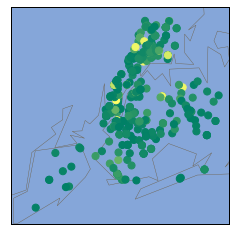

In [27]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=combined["ell_percent"], cmap="summer")
plt.show()

利用basemap包制作了一张按地区显示安全分数的地图。

在这个过程中，我们学会了：
* 如何创建学校和区级地图。
* 如何找到相关性，且相关性意味着什么。
* 为什么我们应该绘制数据，而不是仅仅依赖相关性r值。

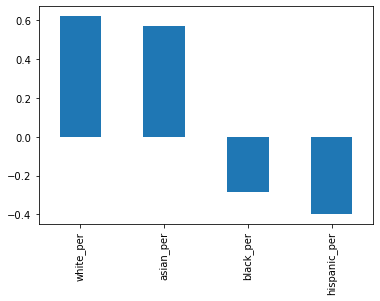

In [52]:
correlations[["white_per","asian_per","black_per","hispanic_per"]].plot(kind='bar')

由该图可以直观的看出["white_per","asian_per","black_per","hispanic_per"]四列与“sat—_score”之间的相关性。

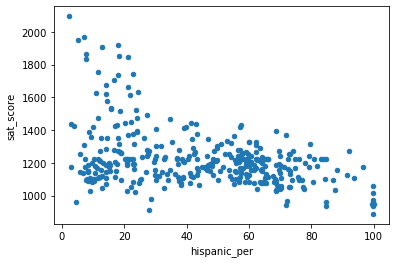

In [133]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

根据hispanic_per与sat_score的散点图的分布，可以看出两者之间呈负相关，证实了上述柱状图该数据的准确性。

In [114]:
for i in range(363):
    if combined["hispanic_per"][i]>95:
        print(combined["SchoolName"][i])

Manhattan Bridges High School
0
GREGORIO LUPERON HS SCI & MATH
Academy for Language and Technology
International School for Liberal Arts
0
Multicultural High School
0


曼哈顿桥中学Manhattan Bridges High School 朱莉娅马斯特曼实验室与示范学校Julia R. Masterman Laboratory and Demonstration School .美国排名前十的高中。
Academy for Language and Technology
International School for Liberal Arts
语言与技术学院
国际文理学院
multicultural high school 
多元文化高中


In [118]:
for i in range(363):
    if combined["hispanic_per"][i]<10 and combined["sat_score"][i]>1800:
        print(combined["SchoolName"][i])

STUYVESANT HS
BRONX HS OF SCIENCE
BROOKLYN TECHNICAL HS
Queens HS for Science York Colllege
STATEN ISLAND TECHNICAL HS


STUYVESANT HS
布朗克斯科学
布鲁克林技术HS
皇后学院科学约克学院
史坦顿岛技术专员

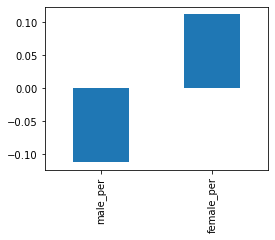

In [123]:
correlations[["male_per","female_per"]].plot(kind='bar',figsize=(4,3))

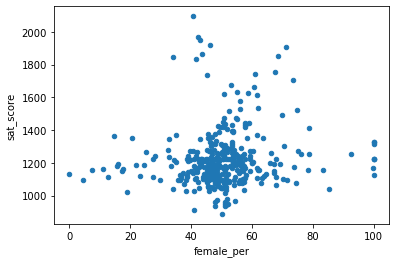

In [129]:
combined.plot.scatter(x='female_per', y='sat_score')

In [125]:
for i in range(363):
    if combined["female_per"][i]>60 and combined["sat_score"][i]>1700:
        print(combined["SchoolName"][i])

0
Eleanor Roosevelt High School
BEACON SCHOOL
FIORELLO H.LAGUARDIA HS
TOWNSEND HARRIS HS


埃莉诺·罗斯福高中
信标学校
FIORELLO H.LAGUARDIA HS
汤森·哈里斯

In [134]:
combined["ap_per"] = combined['AP Test Takers ']/combined['total_enrollment']

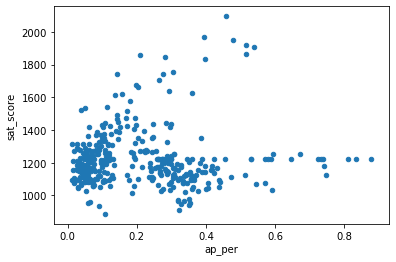

In [130]:
combined.plot.scatter(x='ap_per', y='sat_score')

In [131]:
print(combined)

        DBN                                        SCHOOL NAME  \
0    01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1    01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2    01M450                         EAST SIDE COMMUNITY SCHOOL   
3    01M509                            MARTA VALLE HIGH SCHOOL   
4    01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   
..      ...                                                ...   
358  32K545        EBC HIGH SCHOOL FOR PUBLIC SERVICE–BUSHWICK   
359  32K549                 BUSHWICK SCHOOL FOR SOCIAL JUSTICE   
360  32K552                          ACADEMY OF URBAN PLANNING   
361  32K554               ALL CITY LEADERSHIP SECONDARY SCHOOL   
362  32K556  BUSHWICK LEADERS HIGH SCHOOL FOR ACADEMIC EXCE...   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                       29                            355.0   
1                       91                            383.0   
2                 